## １自由度マニピュレータの動作計画
#### 目標
- 指定した目標角度に対して、ロボットを目標角度に動かす動作を強化学習を用いて獲得

#### 問題の本質
- 今回学習すべき**最適行動**は、現在位置とゴールの差分から、方向・距離を決定できる。  
    - 0° -> 40°: 正方向に40°進む
    - 270°->310°: 正方向に40°進む
    - ⇑どちらも同じ行動として学ぶと効率的に学べそう!!
    


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from env import Arm1DEnv
from visualization import ArmVisualizer

pygame 2.6.1 (SDL 2.28.4, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# 行動を選択(ε-greedy法を使用)
def choice_action(q_table, state, ipsilon=0.2)->int:
    # 探索
    if np.random.rand() < ipsilon:
        return np.random.choice(2)

    # 活用
    else:
        return np.argmax(q_table[state])
    
# 今の状態と取った行動により、Q-tableを更新
def update_q(q_table, now_state, action, next_state, reward, gamma=0.9, lr=0.05):
    best_q = np.max(q_table[next_state])
    # 報酬値 + 割引率 x 次の状態での最大価値
    td_target = reward + gamma * best_q
    q_table[now_state, action] += lr * (td_target - q_table[now_state, action])
    return q_table

In [3]:
# 環境の実体化
arm_env = Arm1DEnv()

# Qテーブルの初期化
q_table = np.zeros((arm_env.n_state, arm_env.action_space), np.float32)

# ハイパパラメータの設定
# 学習エピソード
episode = 10_000
# 最大ステップ数
max_step = 50
# 割引率
gamma = 0.9
# 探索率
init_ipsilon = 0.15 
# 学習率
lr = 0.01 

# log記録用
reward_log = []
finish_count = 0

for i in range(episode):
    total_reward = 0
    ipsilon = max(0.01, init_ipsilon * (0.999 ** i))
    for _ in range(max_step):
        now_state = arm_env.index_state

        # 行動の決定
        action = choice_action(
            q_table=q_table,
            state=now_state,
            ipsilon=ipsilon
        )

        # 行動->報酬・状態を取得
        next_state, reward, is_finish = arm_env.step(action)
        total_reward += reward

        # q-tableの更新
        q_table = update_q(
                        q_table=q_table,
                        now_state=now_state,
                        action=action,
                        next_state=next_state,
                        reward=reward,
                        gamma=gamma,
                        lr=lr
                        )

        # ゴールしたらエピソード終了
        if is_finish:
            # print(arm_env.state, arm_env.start)
            finish_count+=1
            arm_env.reset()
            break

    reward_log.append(total_reward)

In [4]:
finish_count

7655

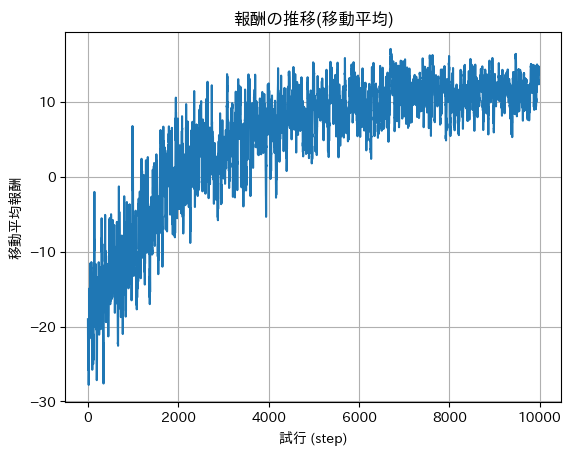

In [5]:
window = 20
moving_avg = np.convolve(reward_log, np.ones(window)/window, mode='valid')

plt.plot(moving_avg)
plt.xlabel("試行 (step)")
plt.ylabel('移動平均報酬')
plt.title("報酬の推移(移動平均)")
plt.grid()
plt.show()

#### 学習モデルを用いて可視化

In [6]:
arm_visu = ArmVisualizer(q_table, arm_env.angle_unit, arm_env.n_state)
arm_visu.run()



クリック -> 目標角度: 70.0°
クリック -> 目標角度: 190.0°
クリック -> 目標角度: 0.0°
クリック -> 目標角度: 330.0°
クリック -> 目標角度: 260.0°
クリック -> 目標角度: 60.0°
クリック -> 目標角度: 240.0°
クリック -> 目標角度: 250.0°
クリック -> 目標角度: 200.0°
クリック -> 目標角度: 30.0°
クリック -> 目標角度: 10.0°
クリック -> 目標角度: 200.0°
クリック -> 目標角度: 210.0°
クリック -> 目標角度: 10.0°
クリック -> 目標角度: 190.0°
クリック -> 目標角度: 350.0°
クリック -> 目標角度: 0.0°
クリック -> 目標角度: 170.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 10.0°
クリック -> 目標角度: 0.0°
クリック -> 目標角度: 160.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 20.0°
クリック -> 目標角度: 350.0°
クリック -> 目標角度: 0.0°
クリック -> 目標角度: 160.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 30.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 40.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 60.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 70.0°
クリック -> 目標角度: 180.0°
クリック -> 目標角度: 70.0°
クリック -> 目標角度: 80.0°
クリック -> 目標角度: 90.0°
クリック -> 目標角度: 100.0°
クリック -> 目標角度: 110.0°
クリック -> 目標角度: 350.0°
クリック -> 目標角度: 140.0°
クリック -> 目標角度: 0.0°
クリック -> 目標角度: 200.0°
クリック -> 目標角度: 70.0°
クリック -> 目標角度: 270.0°


SystemExit: 

/home/yusuke/anaconda3/envs/rl_platform/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
